# KE5105 - Building Electrical Consumption Forecasting

# Extract, Transform and Load Data 2 - Data Exploration

## Summary of Findings

... to be filled in ...

## Load Libraries

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import myUtilities as myUtils

pd.options.display.max_columns = 20

## Load Data

In [2]:
# Load the time series data for 1 building (SDE-3).
sde3_list = myUtils.load_data_by_bldg('SDE-3')
for i in sde3_list[:3]:
    print(i[0], '\n')
    print(i[3].iloc[:5, :], '\n')

SDE-3_May2018.csv 

           Pt_timeStamp PWM-SDE3 IC1 PWM-SDE3 IC2  PWM-SDE3 MCC (AC)  \
0  1/5/2018 12:00:00 AM   847,789.88   525,517.88                0.0   
1  1/5/2018 12:30:00 AM   847,857.44   525,556.69                0.0   
2   1/5/2018 1:00:00 AM   847,920.50   525,595.31                0.0   
3   1/5/2018 1:30:00 AM   847,983.50   525,633.38                0.0   
4   1/5/2018 2:00:00 AM   848,047.50   525,671.50                0.0   

   PWM-CELC IC1 PWM-CELC IC2      PWM-SDE1  PWM-SDE2 SSB  PWM-SDE2 AC  \
0  1,594,258.00   708,561.63  1,170,756.63  3,394,773.50          0.0   
1  1,594,258.00   708,563.88  1,170,760.75  3,394,784.75          0.0   
2  1,594,258.13   708,566.31  1,170,764.75  3,394,795.50          0.0   
3  1,594,258.25   708,568.44  1,170,769.00  3,394,805.50          0.0   
4  1,594,258.38   708,570.63  1,170,773.25  3,394,816.00          0.0   

   PWM-SDE3 Ext PWM-Street Light  BTU-SDE3-Chiller Plant    BTU-SDE3-2  \
0  1,217,990.63         3,246.15  

Note that the date/time is encoded differently for May 2018 (d/m/y) vs Jul 2016 (m/d/y). 

## Explore the date/time field

In [3]:
# Try to convert date/time for May 2018 using default parameters. This does not work.
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'])
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-01-05 00:00:00
day = 5 month =  1 year =  2018


In [4]:
# Try to convert date/time for May 2018 using infer_datetime_format=True. This does not work.
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'], infer_datetime_format=True)
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-01-05 00:00:00
day = 5 month =  1 year =  2018


In [5]:
# Try to convert date/time for May 2018 using dayfirst=True. This works!
print(sde3_list[0][0])
print('raw =', sde3_list[0][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[0][3].loc[:, 'Pt_timeStamp'], dayfirst=True)
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_May2018.csv
raw = 1/5/2018 12:00:00 AM


processed = 2018-05-01 00:00:00
day = 1 month =  5 year =  2018


In [6]:
# Try to convert date/time for Jul 2016 using default parameters. This works.
print(sde3_list[1][0])
print('raw =', sde3_list[1][3].loc[:, 'Pt_timeStamp'][0])
processed_datetime = pd.to_datetime(sde3_list[1][3].loc[:, 'Pt_timeStamp'])
print('processed =', processed_datetime[0])
print('day =', processed_datetime[0].day, 'month = ', processed_datetime[0].month, 'year = ', processed_datetime[0].year)

SDE-3_Jul2016.csv
raw = 7/1/2016 12:00:00 AM


processed = 2016-07-01 00:00:00
day = 1 month =  7 year =  2016


It looks like we have to convert the encoded date/time using different conversion functions. Check through all the files to determine their date/time encoding used.

In [7]:
# Iterate through all the files to check their date/time encoding.
mylist = []
for i in sde3_list:
    if not i[3].empty:
        if i[2] != 1:
            # Check the 1st datetime value.
            mylist.append([i[1], i[2], int(i[3].iloc[0, 0].split('/')[1]) == i[2]])
        else:
            # For Jan, need to check datetime value for 2nd day i.e. 48 x 2 = 96.
            mylist.append([i[1], i[2], int(i[3].iloc[96, 0].split('/')[1]) == i[2]])
            
# Convert list to dataframe. 
datetime_encoding_df = pd.DataFrame(mylist, columns=['year', 'month', 'dayfirst'])

# Reindex the dataframe using the year/month, add missing values for any period with no files. 
datetime_encoding_df['date'] = pd.to_datetime(datetime_encoding_df['year'].astype(str) + '/' + datetime_encoding_df['month'].astype(str))
datetime_encoding_df['date'] = datetime_encoding_df['date'].dt.to_period('M')
datetime_encoding_df.set_index('date', inplace=True)
all_dates = pd.date_range('5/2015', '8/2018', freq='M').to_period('M')
datetime_encoding_df = datetime_encoding_df.reindex(all_dates)
datetime_encoding_df.sort_index(inplace=True)
#datetime_encoding_df = datetime_encoding_df.fillna(-1)

# Convert boolean to numeric for plotting.
datetime_encoding_df['dayfirst'] = datetime_encoding_df['dayfirst'].astype('float')
datetime_encoding_df.head()

,year,month,dayfirst
2015-05,NaN,NaN,NaN
2015-06,2015.0,6.0,0.0
2015-07,2015.0,7.0,0.0
2015-08,2015.0,8.0,0.0
2015-09,2015.0,9.0,0.0


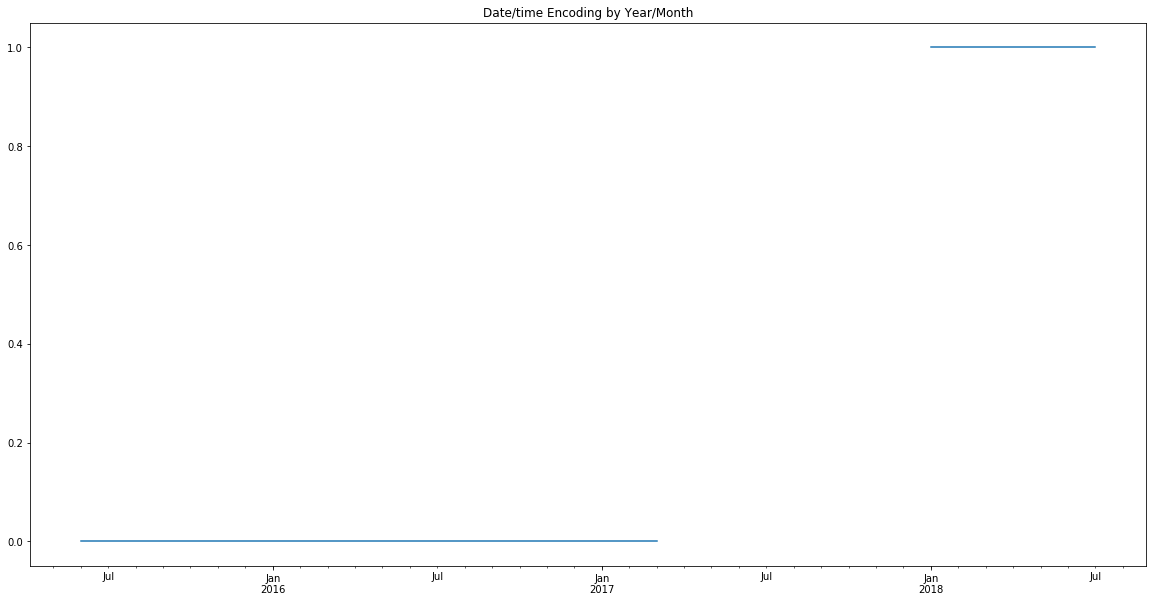

In [8]:
datetime_encoding_df.loc[:, 'dayfirst'].plot(figsize=(20, 10), title='Date/time Encoding by Year/Month')

In the above plot, the legend is :
* missing : no files
* 0       : month first i.e. m/d/y
* 1       : day first i.e. d/m/y

The files are encoded **month first** for the period before the data outage and **day first** after.

## Explore the other data fields

In [9]:
sde3_list[0][3].columns

Index(['Pt_timeStamp', 'PWM-SDE3 IC1', 'PWM-SDE3 IC2', 'PWM-SDE3 MCC (AC)',
       'PWM-CELC IC1', 'PWM-CELC IC2', 'PWM-SDE1', 'PWM-SDE2 SSB',
       'PWM-SDE2 AC', 'PWM-SDE3 Ext', 'PWM-Street Light',
       'BTU-SDE3-Chiller Plant', 'BTU-SDE3-2', 'BTU-SDE3 1&2'],
      dtype='object')

In [10]:
sde3_list[0][3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 14 columns):
Pt_timeStamp              1487 non-null object
PWM-SDE3 IC1              1450 non-null object
PWM-SDE3 IC2              1450 non-null object
PWM-SDE3 MCC (AC)         1450 non-null float64
PWM-CELC IC1              1487 non-null object
PWM-CELC IC2              1487 non-null object
PWM-SDE1                  1483 non-null object
PWM-SDE2 SSB              1486 non-null object
PWM-SDE2 AC               1486 non-null float64
PWM-SDE3 Ext              1483 non-null object
PWM-Street Light          1450 non-null object
BTU-SDE3-Chiller Plant    1450 non-null float64
BTU-SDE3-2                1450 non-null object
BTU-SDE3 1&2              1450 non-null object
dtypes: float64(3), object(11)
memory usage: 162.7+ KB


We need to convert the objects to a numeric type e.g. float for processing.

In [11]:
# There is a mixture of strings and floats.
sde3_list[0][3].loc[:, 'PWM-SDE3 IC1'].apply(lambda x: type(x)).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

In [12]:
# There are commas in the string. These need to be removed before conversion to a numeric type.
sde3_list[0][3].loc[:, 'PWM-SDE3 IC1'].head()

0    847,789.88
1    847,857.44
2    847,920.50
3    847,983.50
4    848,047.50
Name: PWM-SDE3 IC1, dtype: object

In [13]:
# Convert all to string to remove the commas to allow conversion to float.
sde3_list[0][3]['PWM-SDE3 IC1'].astype('str').apply(lambda x: x.replace(',', '')).astype('float').head(20)

0     847789.88
1     847857.44
2     847920.50
3     847983.50
4     848047.50
5     848110.38
6     848173.88
7     848237.81
8     848300.94
9     848364.25
10    848427.50
11    848491.06
12    848554.75
13    848619.25
14    848681.81
15    848741.56
16    848801.81
17    848864.38
18    848927.31
19    848991.88
Name: PWM-SDE3 IC1, dtype: float64

## Convert the time series data for SDE-3.

In [14]:
# Convert the date/time for all the dataframes in the list.
for i in sde3_list:
    if not i[3].empty:
        if myUtils.is_day_first(i[0], i[3]):
            i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'], dayfirst=True)
        else:
            i[3].loc[:, 'Pt_timeStamp'] = pd.to_datetime(i[3].loc[:, 'Pt_timeStamp'])

In [15]:
# Convert the strings to floats for all the dataframes in the list.
for i in sde3_list:
    if not i[3].empty:
        for j in i[3].iloc[:, 1:].columns:
            i[3][j] = i[3][j].astype('str').apply(lambda x: x.replace(',', '')).astype('float')

In [16]:
# Concatenate the list of dataframes into 1 single dataframe.
df_list = []
for i in sde3_list:
    df_list.append(i[3])
sde3_df = pd.concat(df_list)

In [17]:
# The number of data columns (14) after concatenating all the csv files is the same as for the first csv file sampled earlier. The concatenation is successful.
sde3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40460 entries, 0 to 1387
Data columns (total 14 columns):
Pt_timeStamp              40460 non-null datetime64[ns]
PWM-SDE3 IC1              39779 non-null float64
PWM-SDE3 IC2              39779 non-null float64
PWM-SDE3 MCC (AC)         39779 non-null float64
PWM-CELC IC1              39519 non-null float64
PWM-CELC IC2              39519 non-null float64
PWM-SDE1                  40401 non-null float64
PWM-SDE2 SSB              40416 non-null float64
PWM-SDE2 AC               40416 non-null float64
PWM-SDE3 Ext              40401 non-null float64
PWM-Street Light          39779 non-null float64
BTU-SDE3-Chiller Plant    39586 non-null float64
BTU-SDE3-2                39586 non-null float64
BTU-SDE3 1&2              39587 non-null float64
dtypes: datetime64[ns](1), float64(13)
memory usage: 4.6 MB


In [18]:
# Reindex the dataframe using the year/month/day/time, add missing values for any period with no files. 
sde3_df.set_index('Pt_timeStamp', inplace=True)
all_dates = pd.date_range('5/2015', '8/2018', freq='30min')
sde3_df = sde3_df.reindex(all_dates)
sde3_df.sort_index(inplace=True)

In [19]:
# These are the missing values out of the 40460 observations in the time series data. There could also be missing observations i.e. no indexed row. We will look into this later.
sde3_df.isnull().sum()

PWM-SDE3 IC1              17247
PWM-SDE3 IC2              17247
PWM-SDE3 MCC (AC)         17247
PWM-CELC IC1              17508
PWM-CELC IC2              17508
PWM-SDE1                  16631
PWM-SDE2 SSB              16613
PWM-SDE2 AC               16613
PWM-SDE3 Ext              16631
PWM-Street Light          17247
BTU-SDE3-Chiller Plant    17440
BTU-SDE3-2                17440
BTU-SDE3 1&2              17439
dtype: int64

In [20]:
# These are the zero values in the data.
sde3_df.apply(lambda x: x.eq(0)).sum()

PWM-SDE3 IC1                702
PWM-SDE3 IC2                702
PWM-SDE3 MCC (AC)          9524
PWM-CELC IC1                  4
PWM-CELC IC2                  4
PWM-SDE1                   3751
PWM-SDE2 SSB                  0
PWM-SDE2 AC               10161
PWM-SDE3 Ext                  0
PWM-Street Light            702
BTU-SDE3-Chiller Plant     9524
BTU-SDE3-2                    0
BTU-SDE3 1&2                  0
dtype: int64

In [21]:
sde3_PWM_columns = []
for i in sde3_df.columns:
    if 'PWM' in i:
        sde3_PWM_columns.append(i)
sde3_PWM_columns

## Plots of PWM from Jun 2015 to 2018 Jul

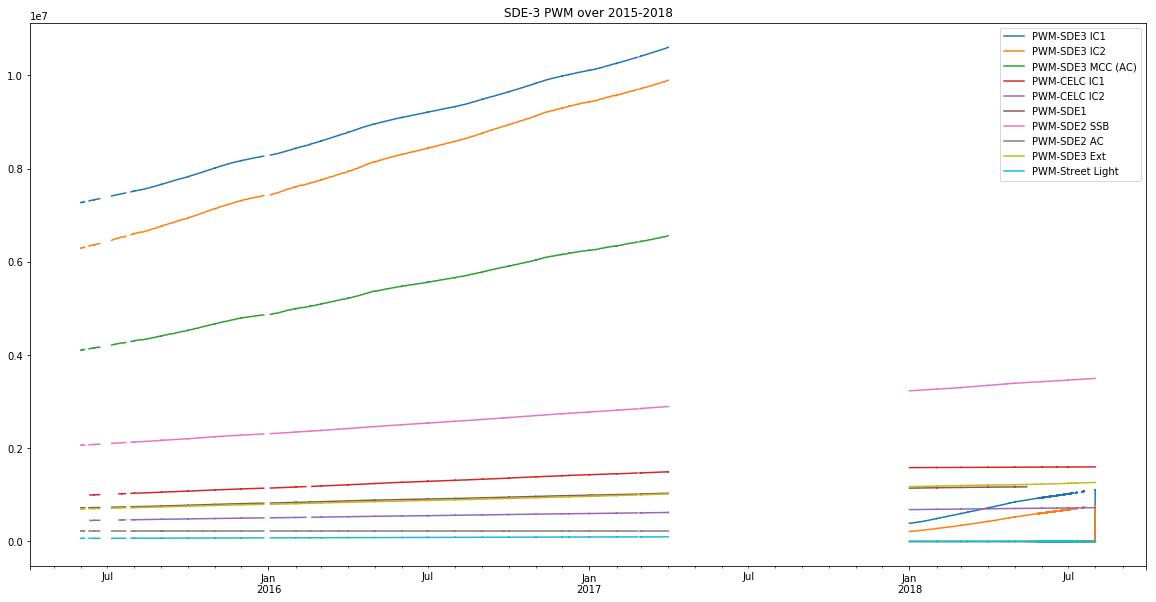

In [22]:
sde3_df.loc[:, sde3_PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2018')

Looking at the csv files :
* For Mar 2017, the values for PWM-SDE3 IC1, PWM-SDE3 IC2 and PWM-SDE3 MCC (AC) are ~10,400,000, ~9,700,000 and 6,400,000 respectively.
* For Jan 2018, the values for PWM-SDE3 IC1 and PWM-SDE3 IC2 are ~390,000, ~214,000 and 0.

There is a **drop in value** in the readings.


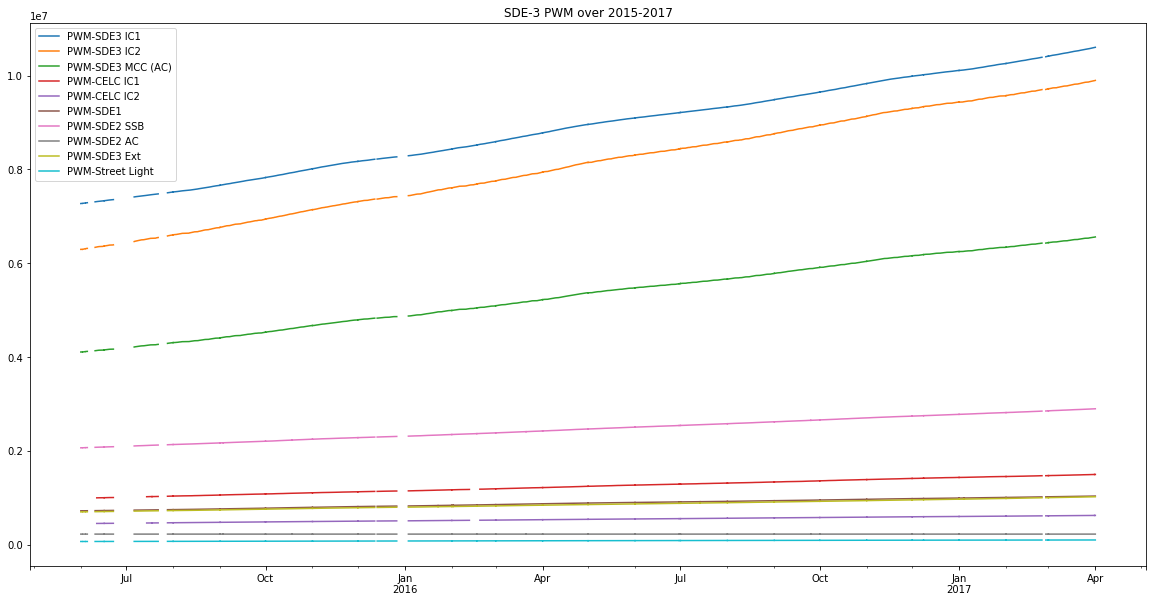

In [23]:
sde3_df.loc['2015-05-01 00H':'2017-05-01 00H', sde3_PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2017')

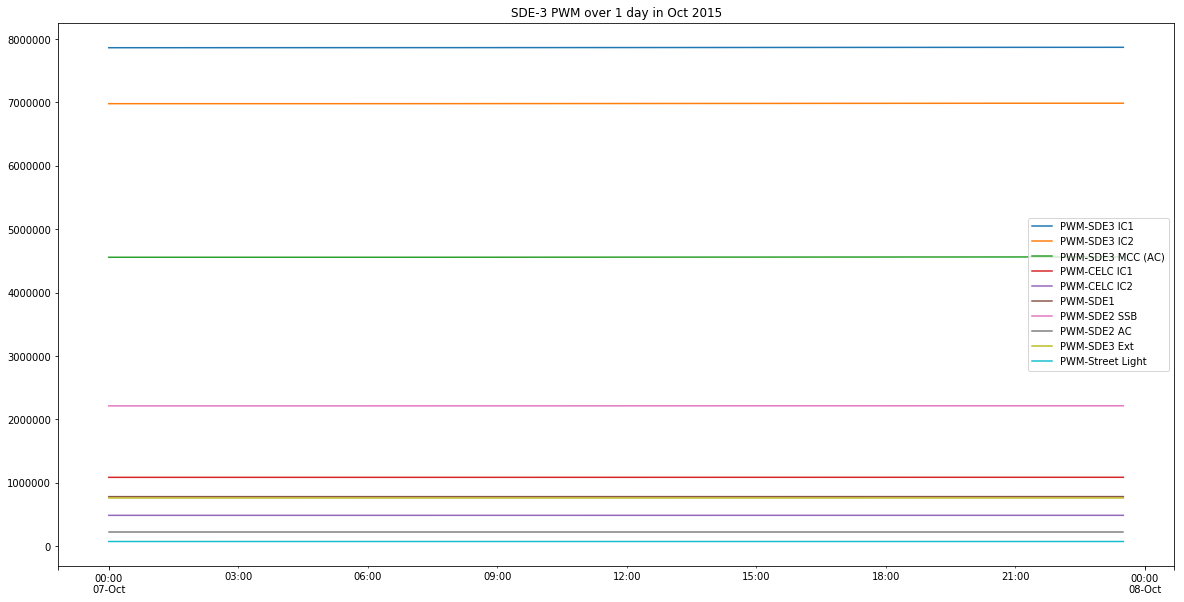

In [24]:
# Explore 1 day (7 Oct) in period before the data outage.
sde3_df.loc['2015-10-07 00H':'2015-10-07 23H', sde3_PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 1 day in Oct 2015')

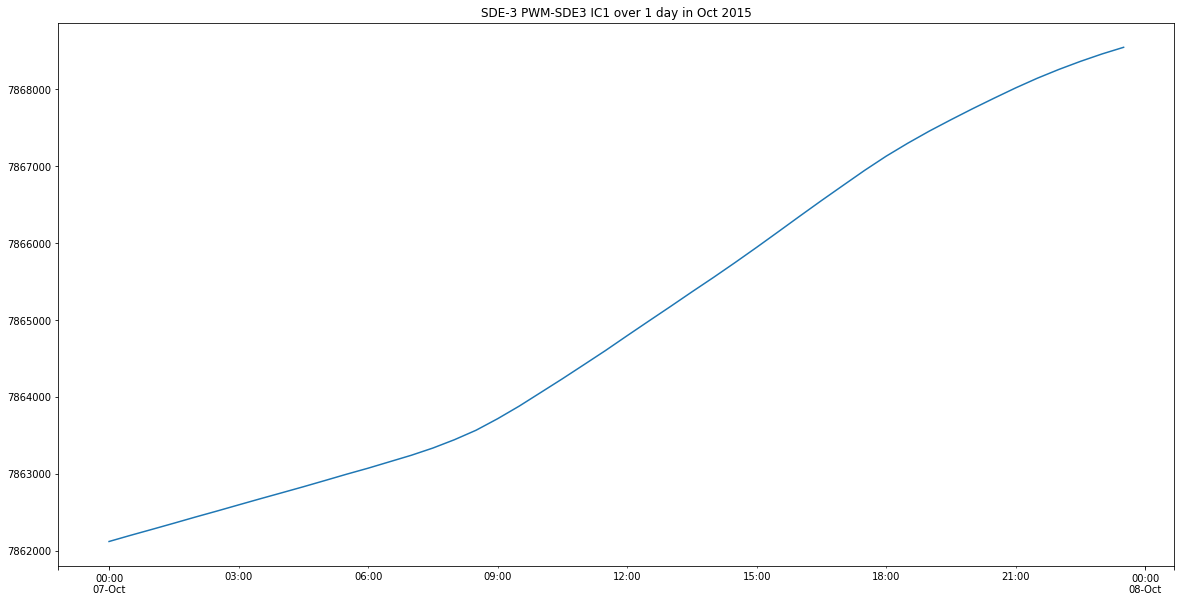

In [25]:
# Explore 1 reading (PWM-SDE3 IC1). 
sde3_df.loc['2015-10-07 00H':'2015-10-07 23H', 'PWM-SDE3 IC1'].plot(figsize=(20, 10), title='SDE-3 PWM-SDE3 IC1 over 1 day in Oct 2015')

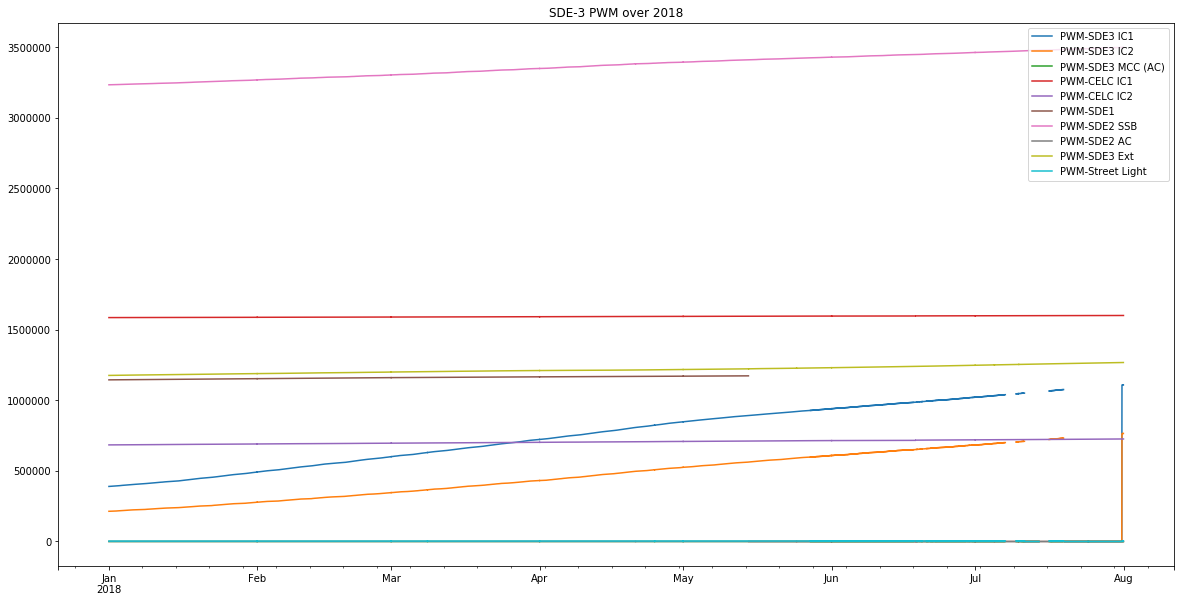

In [26]:
sde3_df.loc['2018-01-01 00H':'2018-08-01 23H', sde3_PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 2018')

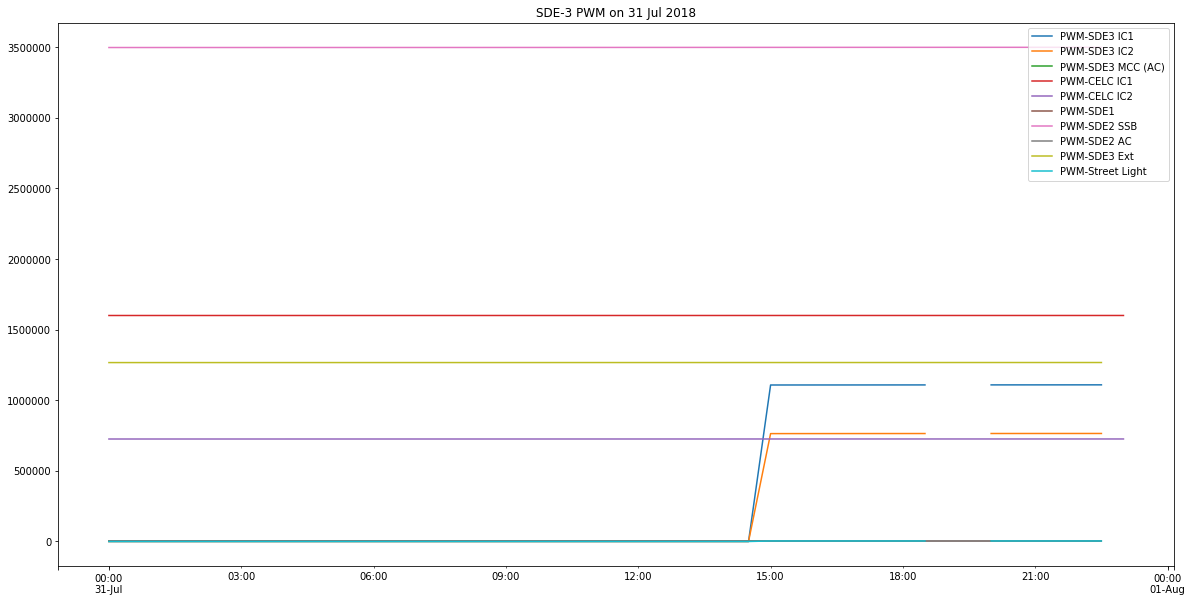

In [27]:
# Explore a day in Jul (31 Jul) when there appears to be missing data.
sde3_df.loc['2018-07-31 00H':'2018-08-01 23H', sde3_PWM_columns].plot(figsize=(20, 10), title='SDE-3 PWM on 31 Jul 2018')

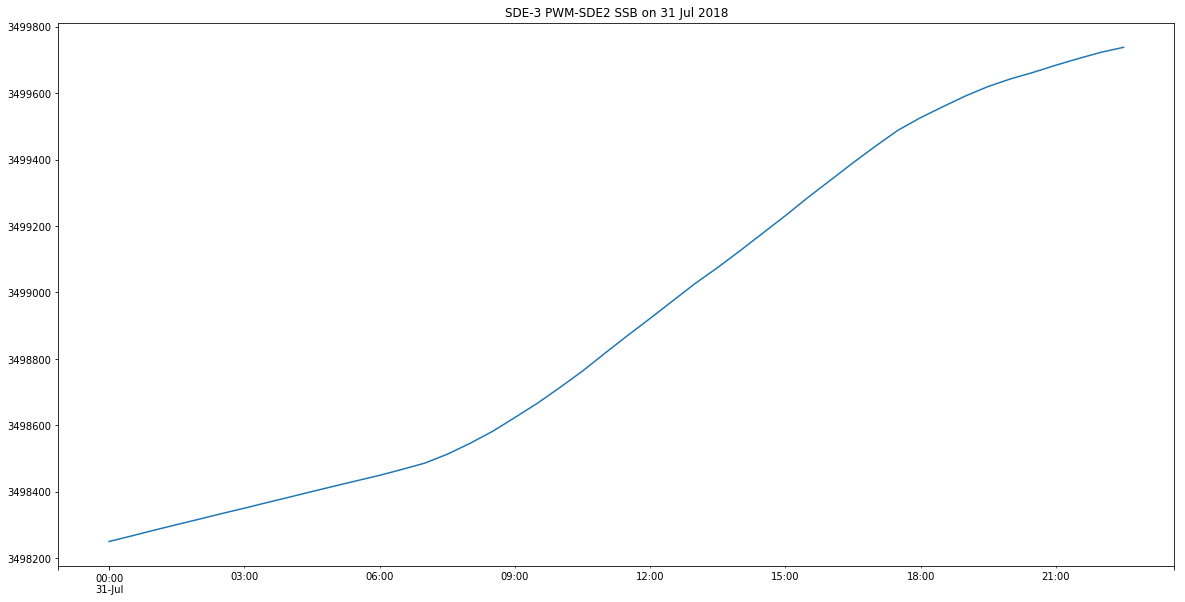

In [28]:
# Explore 1 reading (PWM-SDE2 SSB). 
sde3_df.loc['2018-07-31 00H':'2018-08-01 23H', 'PWM-SDE2 SSB'].plot(figsize=(20, 10), title='SDE-3 PWM-SDE2 SSB on 31 Jul 2018')

The PWM data are **cumulative meter readings**. To get the actual half-hourly meter readings, subtract the current PWM value by the previous value.

## Calculate the Actual Half-hour PWM Values

In [29]:
sde3_df['PWM-SDE3 IC1'][5200:5210]

2015-08-17 08:00:00    7584466.0
2015-08-17 08:30:00    7584584.5
2015-08-17 09:00:00    7584730.0
2015-08-17 09:30:00    7584886.0
2015-08-17 10:00:00    7585045.0
2015-08-17 10:30:00    7585210.0
2015-08-17 11:00:00    7585378.5
2015-08-17 11:30:00    7585550.5
2015-08-17 12:00:00    7585723.5
2015-08-17 12:30:00    7585898.5
Freq: 30T, Name: PWM-SDE3 IC1, dtype: float64

In [30]:
sde3_df['PWM-SDE3 IC1'].diff()[5200:5210]

2015-08-17 08:00:00     99.5
2015-08-17 08:30:00    118.5
2015-08-17 09:00:00    145.5
2015-08-17 09:30:00    156.0
2015-08-17 10:00:00    159.0
2015-08-17 10:30:00    165.0
2015-08-17 11:00:00    168.5
2015-08-17 11:30:00    172.0
2015-08-17 12:00:00    173.0
2015-08-17 12:30:00    175.0
Freq: 30T, Name: PWM-SDE3 IC1, dtype: float64

In [31]:
# Calculate the difference for each column of the data frame,
for i in sde3_df.columns:
    sde3_df[i + '_30min_avg'] = sde3_df[i].diff()

In [32]:
sde3_df.loc[:, sde3_df.columns.str.contains('30min')].iloc[5200:5210, :5]

,PWM-SDE3 IC1_30min_avg,PWM-SDE3 IC2_30min_avg,PWM-SDE3 MCC (AC)_30min_avg,PWM-CELC IC1_30min_avg,PWM-CELC IC2_30min_avg
2015-08-17 08:00:00,99.5,193.0,127.0,30.31,6.40
2015-08-17 08:30:00,118.5,324.5,216.0,61.88,7.66
2015-08-17 09:00:00,145.5,351.5,214.0,92.93,11.34
2015-08-17 09:30:00,156.0,323.0,214.0,62.82,12.41
2015-08-17 10:00:00,159.0,324.0,215.0,66.43,12.69
2015-08-17 10:30:00,165.0,328.5,216.0,67.63,12.65
2015-08-17 11:00:00,168.5,319.0,215.0,58.62,13.22
2015-08-17 11:30:00,172.0,299.5,210.0,46.38,13.44
2015-08-17 12:00:00,173.0,294.5,203.5,49.12,12.94
2015-08-17 12:30:00,175.0,302.0,209.5,49.00,13.06


In [33]:
nrows = len(sde3_df.loc[:, sde3_df.columns.str.contains('30min')])
sde3_df.loc[:, sde3_df.columns.str.contains('30min')].iloc[nrows-25:nrows-15, 0:5]

,PWM-SDE3 IC1_30min_avg,PWM-SDE3 IC2_30min_avg,PWM-SDE3 MCC (AC)_30min_avg,PWM-CELC IC1_30min_avg,PWM-CELC IC2_30min_avg
2018-07-31 12:00:00,0.00,0.00,0.0,4.13,9.87
2018-07-31 12:30:00,0.00,0.00,0.0,4.12,10.75
2018-07-31 13:00:00,0.00,0.00,0.0,3.25,10.00
2018-07-31 13:30:00,0.00,0.00,0.0,3.50,9.38
2018-07-31 14:00:00,0.00,0.00,0.0,3.38,10.25
2018-07-31 14:30:00,0.00,0.00,0.0,3.12,10.06
2018-07-31 15:00:00,1108266.88,763984.06,0.0,3.25,10.37
2018-07-31 15:30:00,86.62,93.82,0.0,3.00,10.00
2018-07-31 16:00:00,76.88,91.37,0.0,3.75,9.50
2018-07-31 16:30:00,70.37,93.19,0.0,3.50,11.07


In [34]:
sde3_df.loc[:, ['PWM-SDE3 IC1', 'PWM-SDE3 IC1']].iloc[nrows-25:nrows-15, 0:5]

,PWM-SDE3 IC1,PWM-SDE3 IC1
2018-07-31 12:00:00,0.00,0.00
2018-07-31 12:30:00,0.00,0.00
2018-07-31 13:00:00,0.00,0.00
2018-07-31 13:30:00,0.00,0.00
2018-07-31 14:00:00,0.00,0.00
2018-07-31 14:30:00,0.00,0.00
2018-07-31 15:00:00,1108266.88,1108266.88
2018-07-31 15:30:00,1108353.50,1108353.50
2018-07-31 16:00:00,1108430.38,1108430.38
2018-07-31 16:30:00,1108500.75,1108500.75


To avoid the above problem of outliers in the diff calculations, we need to convert all zero cumulative values to NaN. The cost of doing this is the loss of valid zero cumulative values and 1 value when the cumulative value turns positive.   

In [35]:
sde3_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57025 entries, 2015-05-01 00:00:00 to 2018-08-01 00:00:00
Freq: 30T
Data columns (total 26 columns):
PWM-SDE3 IC1                        39778 non-null float64
PWM-SDE3 IC2                        39778 non-null float64
PWM-SDE3 MCC (AC)                   39778 non-null float64
PWM-CELC IC1                        39517 non-null float64
PWM-CELC IC2                        39517 non-null float64
PWM-SDE1                            40394 non-null float64
PWM-SDE2 SSB                        40412 non-null float64
PWM-SDE2 AC                         40412 non-null float64
PWM-SDE3 Ext                        40394 non-null float64
PWM-Street Light                    39778 non-null float64
BTU-SDE3-Chiller Plant              39585 non-null float64
BTU-SDE3-2                          39585 non-null float64
BTU-SDE3 1&2                        39586 non-null float64
PWM-SDE3 IC1_30min_avg              39552 non-null float64
PWM-SDE3 IC2_30min_a

In [36]:
sde3_df.replace(to_replace=0.0, value=np.nan, inplace=True)
sde3_df.loc[:, ['PWM-SDE3 IC1', 'PWM-SDE3 IC1']].iloc[nrows-25:nrows-15, 0:5]

,PWM-SDE3 IC1,PWM-SDE3 IC1
2018-07-31 12:00:00,NaN,NaN
2018-07-31 12:30:00,NaN,NaN
2018-07-31 13:00:00,NaN,NaN
2018-07-31 13:30:00,NaN,NaN
2018-07-31 14:00:00,NaN,NaN
2018-07-31 14:30:00,NaN,NaN
2018-07-31 15:00:00,1108266.88,1108266.88
2018-07-31 15:30:00,1108353.50,1108353.50
2018-07-31 16:00:00,1108430.38,1108430.38
2018-07-31 16:30:00,1108500.75,1108500.75


In [37]:
print(sde3_df.columns[np.logical_not(sde3_df.columns.str.contains('avg'))])

Index(['PWM-SDE3 IC1', 'PWM-SDE3 IC2', 'PWM-SDE3 MCC (AC)', 'PWM-CELC IC1',
       'PWM-CELC IC2', 'PWM-SDE1', 'PWM-SDE2 SSB', 'PWM-SDE2 AC',
       'PWM-SDE3 Ext', 'PWM-Street Light', 'BTU-SDE3-Chiller Plant',
       'BTU-SDE3-2', 'BTU-SDE3 1&2'],
      dtype='object')


In [38]:
# Re-calculate the difference for each column of the data frame,
for i in sde3_df.columns[np.logical_not(sde3_df.columns.str.contains('avg'))]:
    sde3_df[i + '_30min_avg'] = sde3_df[i].diff()

In [39]:
sde3_df.loc[:, sde3_df.columns.str.contains('30min')].iloc[nrows-25:nrows-15, 0:5]

,PWM-SDE3 IC1_30min_avg,PWM-SDE3 IC2_30min_avg,PWM-SDE3 MCC (AC)_30min_avg,PWM-CELC IC1_30min_avg,PWM-CELC IC2_30min_avg
2018-07-31 12:00:00,NaN,NaN,NaN,4.13,9.87
2018-07-31 12:30:00,NaN,NaN,NaN,4.12,10.75
2018-07-31 13:00:00,NaN,NaN,NaN,3.25,10.00
2018-07-31 13:30:00,NaN,NaN,NaN,3.50,9.38
2018-07-31 14:00:00,NaN,NaN,NaN,3.38,10.25
2018-07-31 14:30:00,NaN,NaN,NaN,3.12,10.06
2018-07-31 15:00:00,NaN,NaN,NaN,3.25,10.37
2018-07-31 15:30:00,86.62,93.82,NaN,3.00,10.00
2018-07-31 16:00:00,76.88,91.37,NaN,3.75,9.50
2018-07-31 16:30:00,70.37,93.19,NaN,3.50,11.07


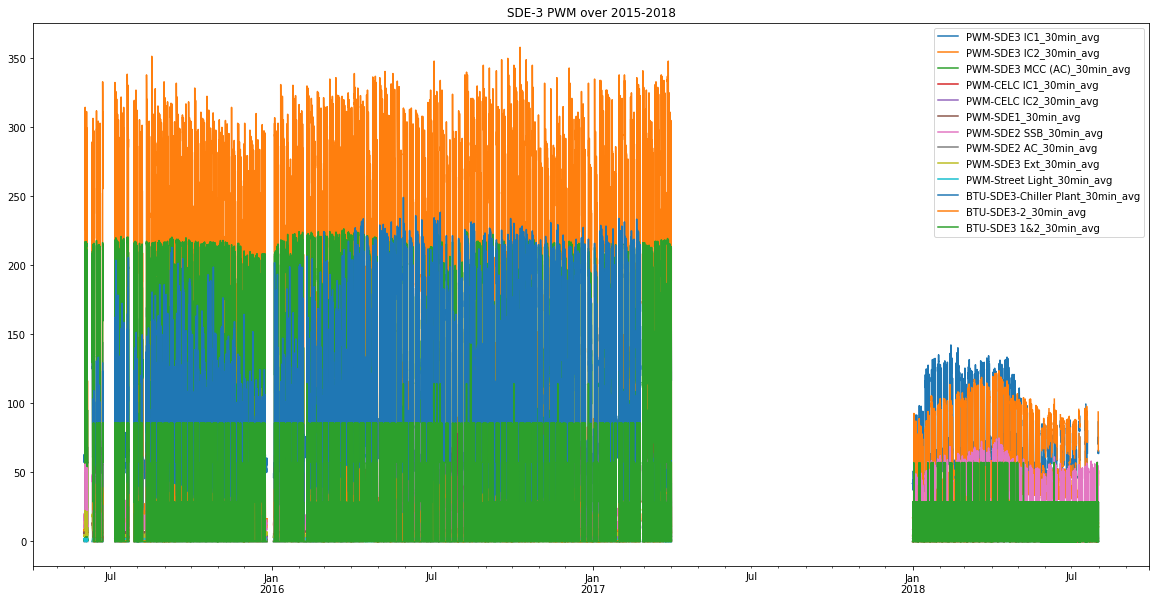

In [40]:
sde3_df.loc[:, sde3_df.columns.str.contains('30min')].plot(figsize=(20, 10), title='SDE-3 PWM over 2015-2018')

In [41]:
sde3_PWM30_columns = []
for i in sde3_df.columns:
    if ('PWM' in i) & ('30' in i):
        sde3_PWM30_columns.append(i)
sde3_PWM30_columns

['PWM-SDE3 IC1_30min_avg',
 'PWM-SDE3 IC2_30min_avg',
 'PWM-SDE3 MCC (AC)_30min_avg',
 'PWM-CELC IC1_30min_avg',
 'PWM-CELC IC2_30min_avg',
 'PWM-SDE1_30min_avg',
 'PWM-SDE2 SSB_30min_avg',
 'PWM-SDE2 AC_30min_avg',
 'PWM-SDE3 Ext_30min_avg',
 'PWM-Street Light_30min_avg']

## Explore Daily Patterns

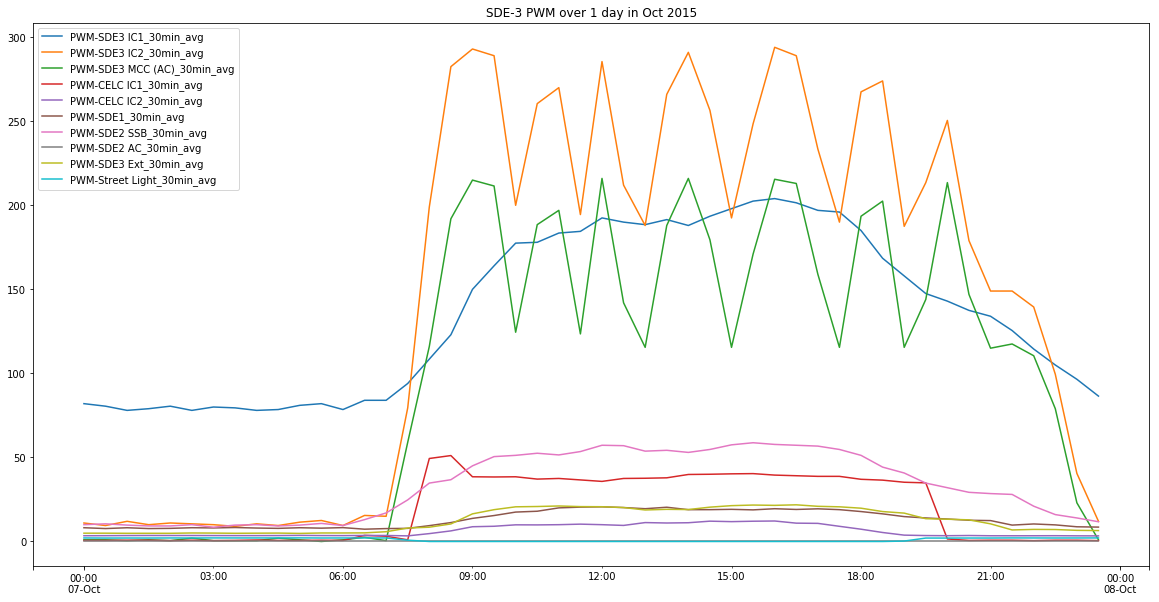

In [42]:
# Explore 1 day (7 Oct) in period before the data outage.
sde3_df.loc['2015-10-07 00H':'2015-10-07 23H', sde3_PWM30_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 1 day in Oct 2015')

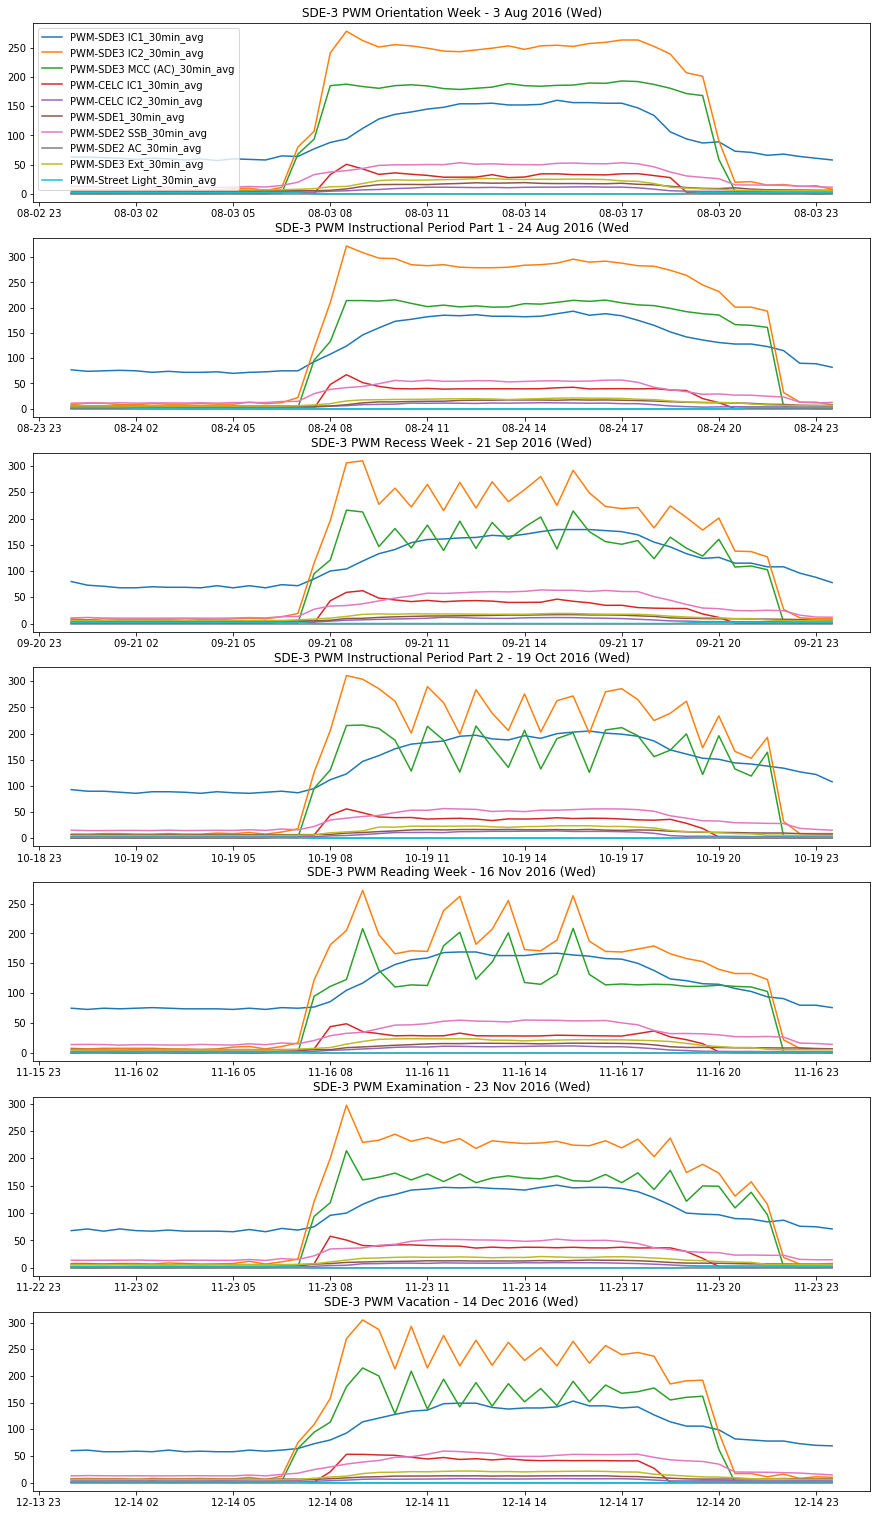

In [43]:
# Plot a day for each period in the academic calendar.
plt.figure(figsize=(15, 27))
plt.subplot(711)
plt.plot(sde3_df.loc['2016-08-03 00H':'2016-08-03 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Orientation Week - 3 Aug 2016 (Wed)')
plt.legend(sde3_PWM30_columns, loc='upper left')
plt.subplot(712)
plt.plot(sde3_df.loc['2016-08-24 00H':'2016-08-24 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Instructional Period Part 1 - 24 Aug 2016 (Wed')
plt.subplot(713)
plt.plot(sde3_df.loc['2016-09-21 00H':'2016-09-21 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Recess Week - 21 Sep 2016 (Wed)')
plt.subplot(714)
plt.plot(sde3_df.loc['2016-10-19 00H':'2016-10-19 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Instructional Period Part 2 - 19 Oct 2016 (Wed)')
plt.subplot(715)
plt.plot(sde3_df.loc['2016-11-16 00H':'2016-11-16 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Reading Week - 16 Nov 2016 (Wed)')
plt.subplot(716)
plt.plot(sde3_df.loc['2016-11-23 00H':'2016-11-23 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Examination - 23 Nov 2016 (Wed)')
plt.subplot(717)
plt.plot(sde3_df.loc['2016-12-14 00H':'2016-12-14 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Vacation - 14 Dec 2016 (Wed)')
plt.show()

## Explore Weekly Patterns

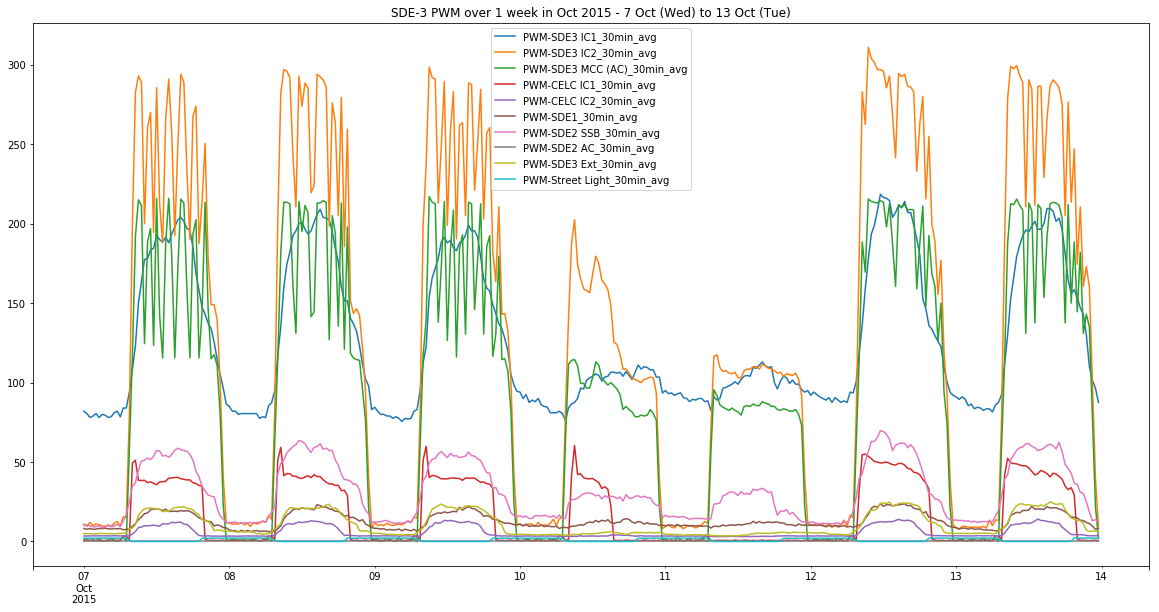

In [44]:
# Explore 1 week (7-13 Oct) during vacation time in the period before the data outage.
sde3_df.loc['2015-10-07 00H':'2015-10-13 23H', sde3_PWM30_columns].plot(figsize=(20, 10), title='SDE-3 PWM over 1 week in Oct 2015 - 7 Oct (Wed) to 13 Oct (Tue)')

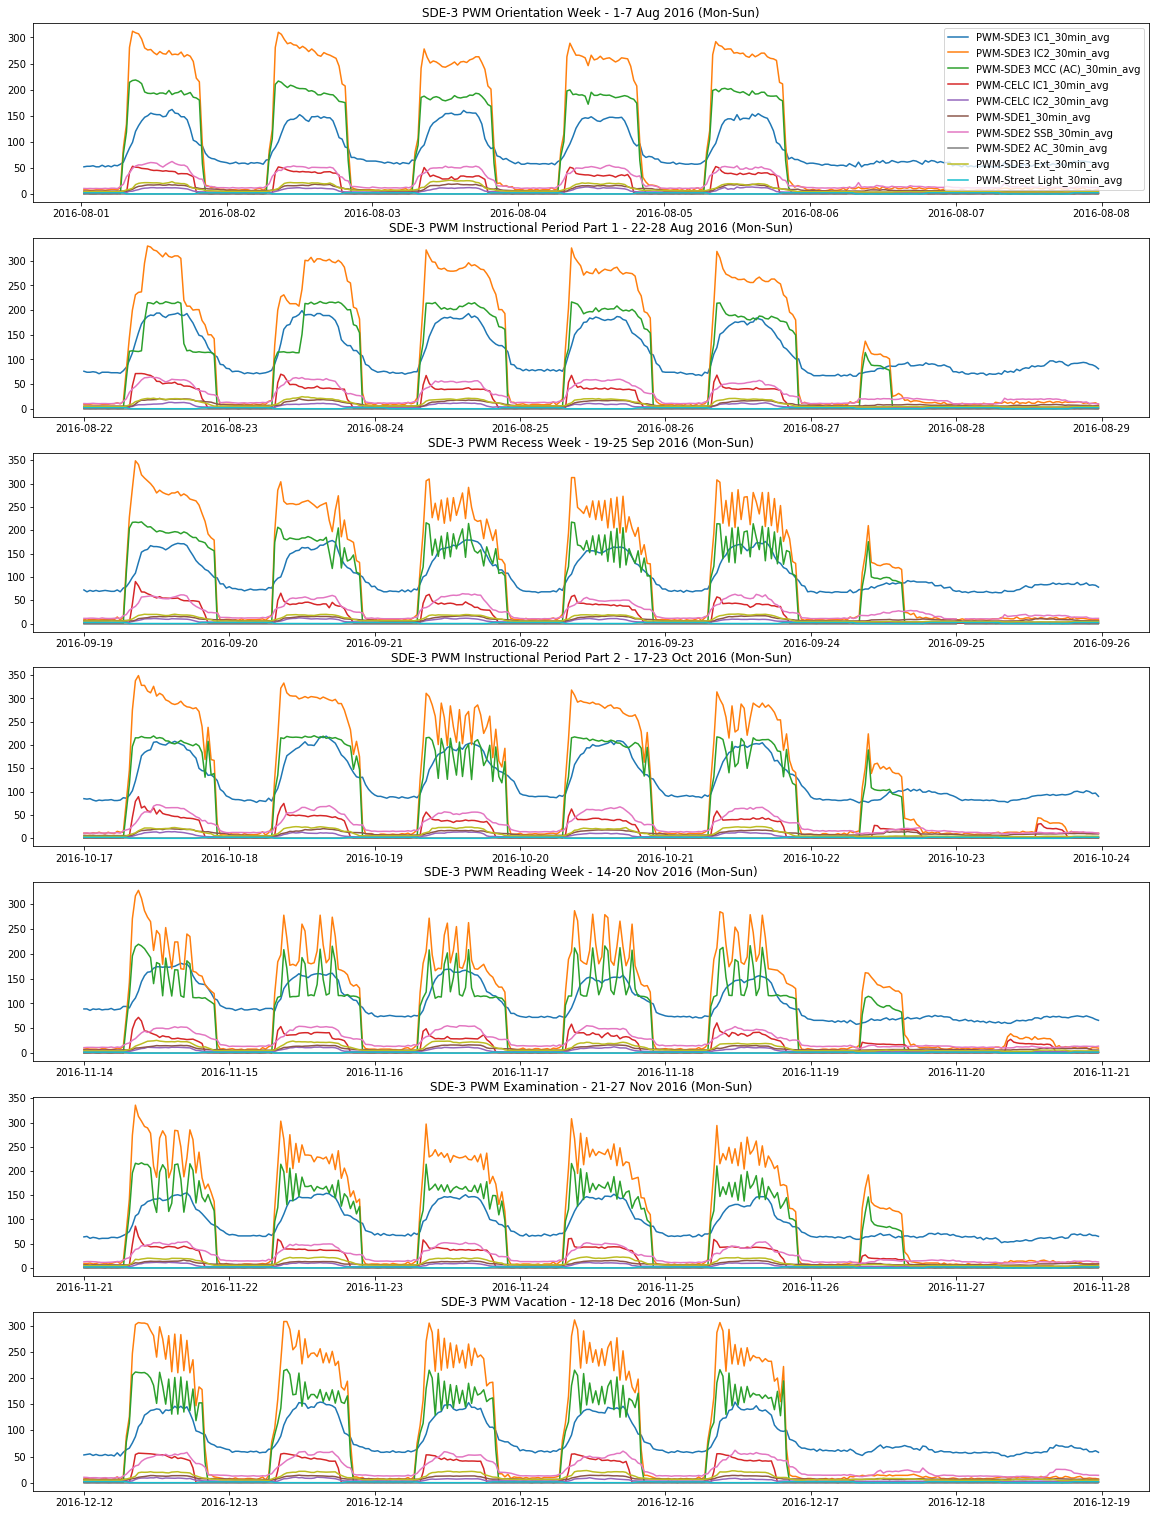

In [57]:
# Plot a week for each period in the academic calendar.
plt.figure(figsize=(20, 27))
plt.subplot(711)
plt.plot(sde3_df.loc['2016-08-01 00H':'2016-08-07 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Orientation Week - 1-7 Aug 2016 (Mon-Sun)')
plt.legend(sde3_PWM30_columns, loc='upper right')
plt.subplot(712)
plt.plot(sde3_df.loc['2016-08-22 00H':'2016-08-28 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Instructional Period Part 1 - 22-28 Aug 2016 (Mon-Sun)')
plt.subplot(713)
plt.plot(sde3_df.loc['2016-09-19 00H':'2016-09-25 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Recess Week - 19-25 Sep 2016 (Mon-Sun)')
plt.subplot(714)
plt.plot(sde3_df.loc['2016-10-17 00H':'2016-10-23 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Instructional Period Part 2 - 17-23 Oct 2016 (Mon-Sun)')
plt.subplot(715)
plt.plot(sde3_df.loc['2016-11-14 00H':'2016-11-20 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Reading Week - 14-20 Nov 2016 (Mon-Sun)')
plt.subplot(716)
plt.plot(sde3_df.loc['2016-11-21 00H':'2016-11-27 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Examination - 21-27 Nov 2016 (Mon-Sun)')
plt.subplot(717)
plt.plot(sde3_df.loc['2016-12-12 00H':'2016-12-18 23H', sde3_PWM30_columns])
plt.title('SDE-3 PWM Vacation - 12-18 Dec 2016 (Mon-Sun)')
plt.show()


## Calculate the PWM according to the Formula for the Building

In [46]:
# sde3_df['PWM'] = sde3_df['PWM-SDE3 IC1'] + sde3_df['PWM-SDE3 IC2'] -\
#                  sde3_df.loc[:, ['PWM-SDE3 MCC (AC)', 'PWM-CELC IC1', 'PWM-CELC IC2', 'PWM-SDE1',
#                               'PWM-SDE2 SSB', 'PWM-SDE2 AC', 'PWM-SDE3 Ext', 'PWM-Street Light']].sum(axis=1, skipna=False)
# sde3_df.loc['2018-07-19 07H':'2018-07-19 12H', sde3_PWM_columns + ['PWM']]


There are **negative values**.

In [47]:
# sde3_df['PWM'].plot(figsize=(20, 10), title='SDE-3 Aggregated PWM over 2015-2018')

In [48]:
# # Plot the aggregated PWM for 1 day before the period of data outage.
# sde3_df.loc['2015-10-07 00H':'2015-10-07 23H', 'PWM'].plot(figsize=(20, 10), title='SDE-3 Aggregated PWM over 1 day in Oct 2015')

In [49]:
# # Plot the aggregated PWM for 1 day after the period of data outage.
# sde3_df.loc['2018-07-19 00H':'2018-07-19 23H', 'PWM'].plot(figsize=(20, 10), title='SDE-3 Aggregated PWM over 1 day in Jul 2018')